In [ ]:
import torch, torchvision, os, PIL, pdb
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from math import ceil
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import gdown, zipfile
import torch.nn as nn
from torchvision import transforms, datasets

In [ ]:
max_levels = 6 # 1: 4x4, 2:8x8, 3:16x16, 4:32x32, 5:64x64, 6:128x128, 7: 256x256
image_size = 128
batch_size = 4

# MNIST dataset parameters
mean_gray = 0.1307
stdd_gray = 0.3081

stats = (0.1307), (0.3081)

In [ ]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [ ]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1] + stats[0]


def show(tensor, num):
  data = tensor.detach().cpu()
  grid = make_grid(denorm(data[:num]), nrow=4).permute(1,2,0)
  plt.imshow(grid.clip(0,1))
  plt.show()


def downsample(images, level):
  level = min(int(ceil(level)), max_levels)
  d = 4 * (2 ** (level - 1))

  return torch.nn.functional.adaptive_avg_pool2d(images, output_size=d)

Dataset Class

In [ ]:
# 1. Dataset Class
class MyDataset(Dataset):
  def __init__(self,remove_list, transform = None, train=True):
    self.mnist = datasets.MNIST(root='./data',
                                download=True,
                                train=train,
                                transform=None)
    self.data = self.mnist.data
    self.targets = self.mnist.targets
    self.transform = transform
    mask = np.ones(len(self.data), dtype=bool)
    mask[remove_list] = False

    self.data = self.data[mask]
    self.targets = self.targets[mask]

  def __getitem__(self, index):
    #data, target = self.final_data[index], self.final_targets[index]
    data, target = self.data[index], self.targets[index]
    #data = data.view(-1, 28, 28)
    data = self.transform(np.array(data))
    return data, target

  def __len__(self):
    #return len(self.final_data)
    return len(self.data)

In [ ]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_gray,),(stdd_gray,))
])

train_dataset = datasets.MNIST(
    root = 'data',
    download = True,
    train = True,
    transform = transformation
)

test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformation
)

In [ ]:
# remove from mnist all non fives
rem_idx_one = ((train_dataset.targets != 5).nonzero(as_tuple=True)[0])
print(rem_idx_one.shape)

traindat_fives = MyDataset(rem_idx_one, transformation, True)
print(len(traindat_fives))

# create reduced subset

remove_idx = ((traindat_fives.targets == 5).nonzero(as_tuple=True)[0])
num = remove_idx.shape[0]
num = ceil(0.99 * num)
print(f'num {num}')

to_remove = remove_idx[:num]
to_keep = remove_idx[num:]
print(f'remove_idx.shape {to_keep.shape}')

trainset_1 = torch.utils.data.Subset(traindat_fives, to_keep)

torch.Size([54579])
5421
num 5367
remove_idx.shape torch.Size([54])


In [ ]:
# 4. Dataset Initialization

trainloader = DataLoader(
    #dataset = train_dataset,
    dataset = trainset_1,
    batch_size = batch_size,
    shuffle = True
)

num_steps = len(trainloader) // batch_size
num_steps

3

torch.Size([4, 1, 28, 28])


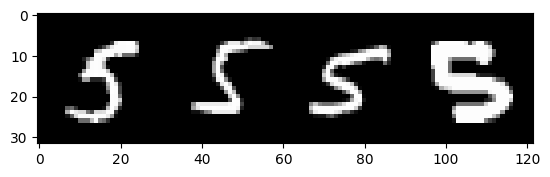

In [ ]:
# dataset visualization
ha, labels = next(iter(trainloader))

print(ha.shape)
show(ha, 4)

PixelWise Norm

In [ ]:
# PixelWise Normalization

class PixelWiseNorm(nn.Module):
  def __init__(self):
    super(PixelWiseNorm, self).__init__()

  def forward(self, a):
    ## alpha is the original unormalized feature vector
    epsilon = 1e-8
    return a / torch.sqrt(
        torch.mean(a**2, dim=1, keepdim=True) + epsilon
    )

Weight Initialization

In [ ]:
class WeightScaler(nn.Module):
  def __init__(self, incoming, gain=2):
    super(WeightScaler, self).__init__()

    self.gain = gain
    self.scale = (self.gain / incoming.weight[0].numel()) ** 0.5

  def forward(self, input):
    return input * self.scale

Generator & Discriminator

In [ ]:
nc = 1 # number of color channels of train images

z_dim = 64 # latent space vector size

ngf = 6 # size of generator's feature map

ndf = 6 # size of discriminators feature map

In [ ]:
# Discriminator

def dConvBlock(inp, out, f, s, p, bias):
  return nn.Sequential(
      nn.Conv2d(inp, out, f, s, p, bias=bias),
      #nn.InstanceNorm2d(out),
      nn.LeakyReLU(0.2, inplace=True),
  )

class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.fromRGBs = nn.ModuleList()
    self.blocks = nn.ModuleList()

    i = 0 # channel size
    j = 4 # size

    while j <= image_size:

      in_channels = int(ndf * (2**i))       # i=0,  ndf,  i=1, 2*ndf ...
      out_channels = int(ndf * (2**(i+1)))  # i=0, ndf*2, i=1, ndf*4 ...

      self.fromRGBs.append(
          nn.Sequential(
              nn.Conv2d(nc, in_channels, 1, 1, 0, bias=False),
              #nn.LeakyReLU(0.2, True)
          )
      )

      self.blocks.append(
          nn.Sequential(
              dConvBlock(in_channels, in_channels, 4, 2, 1, bias=False),
              dConvBlock(in_channels, out_channels, 1, 1, 0, bias=False),
          )
      )

      i = i + 1
      j = j * 2

    # Last block
    self.blocks.append(
        nn.Sequential(
            nn.Conv2d(ndf * (2 ** (i+1)), 1, 2, 1, 0, bias=False),
            #nn.Sigmoid()
        )
    )

    # Weight Initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  # 1: 4x4, 2:8x8, 3: 16x16, 4: 32x32, 5: 64x64
  def forward(self, inputs, level):

    #print('a')
    alpha_temp = level - int(level)
    level = min(int(ceil(level)), max_levels)

    feature_map = self.fromRGBs[max_levels - level](inputs)
    #print(f'feature map shape: {feature_map.shape}')
    feature_map = self.blocks[max_levels - level](feature_map)


    # alpha transition
    if level > 1 and alpha_temp != 0:
      # downsample 0.5x
      prev_input = nn.functional.avg_pool2d(inputs, 2, 2)

      prev_feature_map = self.fromRGBs[max_levels - level + 1](prev_input)

      # alpha merge
      feature_map = alpha_temp * feature_map + (1-alpha_temp) * prev_feature_map

    for i in range(max_levels - level + 1, max_levels):
      feature_map = self.blocks[i](feature_map)

    # standard dev. for each mini batch
    st_dev = torch.std(feature_map, dim=0)
    # concatenate st. dev and feature map
    y = torch.cat([feature_map, st_dev.unsqueeze(0).expand_as(feature_map)], dim=1)
    #print(f'y map shape: {y.shape}')

    # pass through last layer
    ret = self.blocks[-1](y).view(-1, 1)

    return ret

In [ ]:
# Generator

def gConvBlock(inp, out, f, s, p, bias):
  return nn.Sequential(
      nn.ConvTranspose2d(inp, out, f, s, p, bias=bias),
      nn.BatchNorm2d(out),
      #nn.ReLU(inplace=True),
      nn.LeakyReLU(0.2,inplace=True),
      #PixelWiseNorm()
  )


class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.blocks = nn.ModuleList()
    self.toRGBs = nn.ModuleList()

    # first conv block
    self.blocks.append(
        nn.Sequential(
            gConvBlock(z_dim, ngf*64, 4, 1, 0, bias=False),     # why not 64 (2^5) instead of 48??
            gConvBlock(ngf*64, ngf*32, 1, 1, 0, bias=False)
        )
    )


    i = 5 # channel sentiment
    j = 4 # size sentiment

    while j <= image_size:

      inp_channels = int(ngf * (2**i))
      out_channels = int(ngf * (2**(i-1)))

      self.blocks.append(
          nn.Sequential(
              gConvBlock(inp_channels, inp_channels, 4, 2, 1, bias=False),
              gConvBlock(inp_channels, out_channels, 1, 1, 0, bias=False)
          )
      )

      self.toRGBs.append(
          nn.Sequential(
              nn.ConvTranspose2d(inp_channels, nc, 1, 1, 0, bias=False),
              nn.Tanh()
          )
      )

      i = i - 1
      j = j * 2

    # Weight Initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


  def forward(self, inputs, level):

    #alpha = level - int(level)
    alpha_temp = level - int(level)
    level = min(int(ceil(level)), max_levels)

    feature_map = self.blocks[0](inputs)
    #temp_map = feature_map

    #print(f'level: {level}')
    #print(f'feature_map: {feature_map.shape}')

    for i in range(1, level):

      #feature_map = self.blocks[i](feature_map)
      #print(f'feature_map: {feature_map.shape}')

      # alpha transition
      if level > 1 and i == level-1 and alpha_temp != 0:
        #print(f'level {level}')
        # upsample 2x
        prev_output = nn.functional.interpolate(
            #temp_map,
            feature_map,
            scale_factor=2
        )
        #print(f'prev_output: {prev_output.shape}')

        prev_output = self.toRGBs[i-1](prev_output)
        #print(f'prev_output: {prev_output.shape}')
      feature_map = self.blocks[i](feature_map)
      #print(f'feature_map: {feature_map.shape}')

      #temp_map = feature_map

    output = self.toRGBs[level-1](feature_map)
    #print(f'output: {output.shape}')
    #print(f'prev_output: {prev_output.shape}')

    if alpha_temp != 0:
      #return output * alpha + prev_output * ( 1 - alpha )
      return output * (alpha_temp) + prev_output * ( 1-alpha_temp )
    else:
      return output


def gen_noise(batch_size, z_dim, device):
  return torch.randn(batch_size, z_dim, device = device).view(-1, z_dim, 1, 1)

In [ ]:
noo = gen_noise(4, 32, device)
print(noo.shape)
gena=gen(noo, 3)
print(gena.shape)

disc(gena, 3).shape

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
lr = 0.00025

# Setup Adam optimizers for both G and D
disc_optim = torch.optim.Adam(
    disc.parameters(),
    lr=lr,
    betas=(0.5,0.9)
)

gen_optim = torch.optim.Adam(
    gen.parameters(),
    lr=lr,
    betas=(0.5,0.9)
)

criterion = torch.nn.BCELoss()

In [ ]:
fixed_noise = torch.randn(4, z_dim, 1, 1).to(device)

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

In [ ]:
noise = gen_noise(4, z_dim, device)
fake = gen(noise, 1)

disc(fake, 1).shape

torch.Size([4, 1])

In [ ]:
# standardize to range [0 - 1] then scale to range [1, max_levels]
def updateLevel(epoch, step, total_epochs, total_steps, max_levels):

    total_spectrum = total_epochs * total_steps

    current_point = epoch * total_steps + step

    return min( max( (current_point / total_spectrum ) * max_levels, 4), max_levels)
    #return min( max( (current_point / total_spectrum ) * 3.97, 1), 3.97)

In [ ]:
# Gradient Penalty Calculation

def get_gp(real, fake, crit, alpha, level, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images, level) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [ ]:
num_steps = len(trainloader) // batch_size
num_steps

3

In [ ]:
# (Optional)

# save and load checkpoints

#root_path='./data/'

from google.colab import drive
#drive.mount('/content/gdrive')
root_path='/content/drive/MyDrive/Colab/models'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'level': level,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_optim.state_dict()
  }, f'{root_path}G-{name}.pkl')

  torch.save({
      'epoch': epoch,
      'level': level,
      'model_state_dict': disc.state_dict(),
      'optimizer_state_dict': disc_optim.state_dict()
  }, f'{root_path}C-{name}.pkl')

  print('Saved checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}G-{name}.pkl')
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_optim.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f'{root_path}C-{name}.pkl')
  disc.load_state_dict(checkpoint['model_state_dict'])
  disc_optim.load_state_dict(checkpoint['optimizer_state_dict'])

  epoch = checkpoint['epoch']
  level = checkpoint['level']

  print('Loaded checkpoint')
  return checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
chkpnt = load_checkpoint('progan_v3_LeakyRELUgen_mnist')

Loaded checkpoint


In [ ]:
epoch = chkpnt['epoch']
level = chkpnt['level']

In [ ]:
print(epoch)

1980


In [ ]:
epoch = 0

In [ ]:
epochs = 5000
total_steps = int(ceil(len(trainset_1) / batch_size))
crit_cycles = 4
total_steps = int(trainset_1.__len__() / batch_size)
print_step = int(total_steps ) - 2
inf_step = int(total_steps ) - 2
show_step = 3
crit_losses = []
gen_losses=[]

#for epoch in tqdm(range(epochs)):
while epoch < epochs:
  d_loss = 0
  g_loss = 0
  cur_step = 0

  for i, (real, _) in enumerate(trainloader):

    cur_bs = int(len(real))
    level = updateLevel(epoch, i, epochs, num_steps, max_levels) + 0.00009


    real = downsample(real, level)
    real = real.to(device)

    rls = torch.ones(len(real), 1)
    fls = torch.zeros(len(real), 1)
    rls = rls.to(device)
    fls = fls.to(device)

    mean_crit_loss = 0


    disc_optim.zero_grad()
    for k in range(crit_cycles):
      #d_loss += trainDisc(disc, disc_optim, gen, criterion, images, level, rls, fls, len(real))

      # generate fake images
      noise = gen_noise(cur_bs, z_dim, device)
      fake = gen(noise, level)

      # get discriminators output
      fake_out = disc(fake.detach(), level)
      real_out = disc(real, level)

      # calculate loss
      alpha = torch.rand(cur_bs, 1, 1, 1, device=device, requires_grad=True)
      gamma= 10
      gp = get_gp(real, fake.detach(), disc, alpha, level, gamma)
      c_f_d = fake_out.mean()
      c_r_d = real_out.mean()

      # calculate backward prop.
      crit_loss = c_f_d - c_r_d + gp #+ (0.001 * torch.mean(real_out ** 2))
      crit_loss.backward()

      # optimizer step
      disc_optim.step()

    mean_crit_loss+=crit_loss.item() / crit_cycles
    crit_losses+=[mean_crit_loss]

    # Generator loss
    #g_loss += trainGen(gen, gen_optim, disc, criterion, level, rls, len(real))
    gen_optim.zero_grad()

    # generate fake images
    noise = gen_noise(cur_bs, z_dim, device)
    fake = gen(noise, level)

    # get discriminator's verdict
    fake_out = disc(fake, level)

    # calculate loss
    g_loss = -fake_out.mean()
    g_loss.backward()

    # optimizer step
    gen_optim.step()

    gen_losses+=[g_loss.item()]


    if epoch% 20 == 0 and cur_step % print_step == 0 and cur_step> 0:
      gen_mean=sum(gen_losses[-print_step:]) / print_step
      crit_mean = sum(crit_losses[-print_step:]) / print_step
      print(f"\n Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}, level: {level}")

    if epoch% 20 == 0 and cur_step % show_step == 0 and cur_step> 0:
      #save_checkpoint('latest_wgan_celeba')
      generated = gen(fixed_noise, level)
      show(generated, 12)

    if epoch% 20 == 0 and cur_step % inf_step == 0 and cur_step> 0:
      plt.plot(
            range(len(gen_losses)),
            torch.Tensor(gen_losses),
            label="Generator Loss"
        )

      plt.plot(
            range(len(gen_losses)),
            torch.Tensor(crit_losses),
            label = 'Critic Loss'
        )
      y1=max(crit_losses)
      y2=max(gen_losses)
      y=max(y1, y2) + 10

      plt.ylim(-y,y)
      plt.legend()
      plt.show()

    cur_step += 1

  if epoch % 20 == 0 and epoch > 0 :
    save_checkpoint('progan_v3_LeakyRELUgen_mnist')
  epoch += 1

In [ ]:
save_checkpoint('progan_v3_LeakyRELUgen_mnist')

Saved checkpoint


Generating images

In [ ]:
load_checkpoint('progan_v3_LeakyRELUgen_mnist')

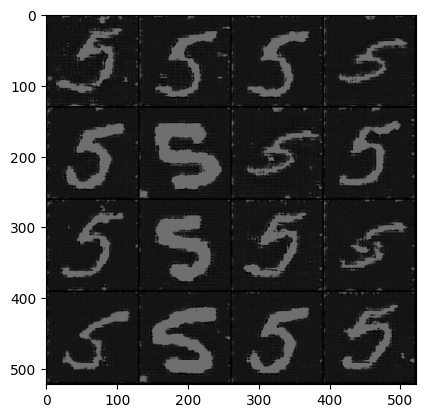

In [ ]:
noise = gen_noise(16, z_dim, device)
generated = gen(noise, 6)
#generated = torch.nn.functional.adaptive_avg_pool2d(generated, output_size=28)
show(generated, 16)

In [ ]:
from torchvision.utils import save_image

for i in range(1, 100):
 noise = gen_noise(1, z_dim, device)
 generated = gen(noise, 6)
 #generated = torch.nn.functional.adaptive_avg_pool2d(generated, output_size=28)
 name = f'img{i}.png'
 save_image(generated, f'/content/drive/MyDrive/generated_mnist2/{name}')